In [5]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Model Garden - Flux

<table><tbody><tr>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fvertex-ai-samples%2Fmain%2Fnotebooks%2Fcommunity%2Fmodel_garden%2Fmodel_garden_pytorch_flux.ipynb">
      <img alt="Google Cloud Colab Enterprise logo" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" width="32px"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_pytorch_flux.ipynb">
      <img alt="GitHub logo" src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" width="32px"><br> View on GitHub
    </a>
  </td>
</tr></tbody></table>

## Overview

This notebook demonstrates deploying the pre-trained [Flux.1 [schnell]](https://huggingface.co/black-forest-labs/FLUX.1-schnell) model on Vertex AI for online prediction.

### Objective

- Upload the model to [Model Registry](https://cloud.google.com/vertex-ai/docs/model-registry/introduction).
- Deploy the model on [Endpoint](https://cloud.google.com/vertex-ai/docs/predictions/using-private-endpoints).
- Run online predictions for text-to-image.

## TASK (GO TO COMMAND line - same terminal as your kernel)
pip install huggingface_hub
huggingface-cli login
#### then enter the token where accepted t&Cs 


## Run the notebook

In [1]:
# @title Setup Google Cloud project

# @markdown 1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

# @markdown 2. [Optional] [Create a Cloud Storage bucket](https://cloud.google.com/storage/docs/creating-buckets) for storing experiment outputs. Set the BUCKET_URI for the experiment environment. The specified Cloud Storage bucket (`BUCKET_URI`) should be located in the same region as where the notebook was launched. Note that a multi-region bucket (eg. "us") is not considered a match for a single region covered by the multi-region range (eg. "us-central1"). If not set, a unique GCS bucket will be created instead.

import base64
import importlib
import os
import uuid
from datetime import datetime
from io import BytesIO

from google.cloud import aiplatform
from PIL import Image

# Get the default cloud project id.
PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]

# Get the default region for launching jobs.
REGION = 'us-central1'

# Enable the Vertex AI API and Compute Engine API, if not already.
print("Enabling Vertex AI API and Compute Engine API.")
! gcloud services enable aiplatform.googleapis.com compute.googleapis.com

# Cloud Storage bucket for storing the experiment artifacts.
# A unique GCS bucket will be created for the purpose of this notebook. If you
# prefer using your own GCS bucket, change the value yourself below.
now = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET_URI = "gs://"  # @param {type:"string"}
BUCKET_NAME = "/".join(BUCKET_URI.split("/")[:3])

if BUCKET_URI is None or BUCKET_URI.strip() == "" or BUCKET_URI == "gs://":
    BUCKET_URI = f"gs://{PROJECT_ID}-tmp-{now}-{str(uuid.uuid4())[:4]}"
    BUCKET_NAME = "/".join(BUCKET_URI.split("/")[:3])
    ! gsutil mb -l {REGION} {BUCKET_URI}
else:
    assert BUCKET_URI.startswith("gs://"), "BUCKET_URI must start with `gs://`."
    shell_output = ! gsutil ls -Lb {BUCKET_NAME} | grep "Location constraint:" | sed "s/Location constraint://"
    bucket_region = shell_output[0].strip().lower()
    if bucket_region != REGION:
        raise ValueError(
            "Bucket region %s is different from notebook region %s"
            % (bucket_region, REGION)
        )
print(f"Using this GCS Bucket: {BUCKET_URI}")

STAGING_BUCKET = os.path.join(BUCKET_URI, "temporal")
MODEL_BUCKET = os.path.join(BUCKET_URI, "flux")


# Initialize Vertex AI API.
print("Initializing Vertex AI API.")
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=STAGING_BUCKET)

# Gets the default SERVICE_ACCOUNT.
shell_output = ! gcloud projects describe $PROJECT_ID
project_number = shell_output[-1].split(":")[1].strip().replace("'", "")
SERVICE_ACCOUNT = f"{project_number}-compute@developer.gserviceaccount.com"
print("Using this default Service Account:", SERVICE_ACCOUNT)


# Provision permissions to the SERVICE_ACCOUNT with the GCS bucket
! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.admin $BUCKET_NAME

! gcloud config set project $PROJECT_ID

models, endpoints = {}, {}

! git clone https://github.com/GoogleCloudPlatform/vertex-ai-samples.git

common_util = importlib.import_module(
    "vertex-ai-samples.community-content.vertex_model_garden.model_oss.notebook_util.common_util"
)


def base64_to_image(image_str):
    """Convert base64 encoded string to an image."""
    image = Image.open(BytesIO(base64.b64decode(image_str)))
    return image


def image_grid(imgs, rows=2, cols=2):
    w, h = imgs[0].size
    grid = Image.new(
        mode="RGB", size=(cols * w + 10 * cols, rows * h), color=(255, 255, 255)
    )
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w + 10 * i, i // cols * h))
    return grid

Enabling Vertex AI API and Compute Engine API.
Operation "operations/acat.p2-255766800726-32ad062b-05d1-4732-86af-d27059e5f40a" finished successfully.
Creating gs://my-project-0004-346516-tmp-20240902081046-21ef/...
Using this GCS Bucket: gs://my-project-0004-346516-tmp-20240902081046-21ef
Initializing Vertex AI API.
Using this default Service Account: 255766800726-compute@developer.gserviceaccount.com
Updated property [core/project].
Cloning into 'vertex-ai-samples'...
remote: Enumerating objects: 40185, done.
remote: Counting objects: 100% (8405/8405), done.
remote: Compressing objects: 100% (202/202), done.
remote: Total 40185 (delta 8304), reused 8254 (delta 8203), pack-reused 31780 (from 1)
Receiving objects: 100% (40185/40185), 94.34 MiB | 34.86 MiB/s, done.
Resolving deltas: 100% (30911/30911), done.


2024-09-02 08:10:58.160805: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-02 08:11:14.449334: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-09-02 08:11:14.450135: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-09-02 08:11:14.450153: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [4]:
# @title Deploy the model to Vertex for online predictions

# @markdown This section uploads the [black-forest-labs/FLUX.1-schnell](https://huggingface.co/black-forest-labs/FLUX.1-schnell) model to Model Registry and deploys it on the Endpoint with 1 A100 80G GPU.

# @markdown The deployment takes ~15 minutes to finish.

model_id = "black-forest-labs/FLUX.1-schnell"
task = "text-to-image"

accelerator_type = "NVIDIA_TESLA_A100" # "NVIDIA_A100_80GB"
machine_type = "a2-highgpu-1g" #  "a2-ultragpu-1g"
accelerator_count = 1

# The pre-built serving docker image. It contains serving scripts and models.
SERVE_DOCKER_URI = "us-docker.pkg.dev/deeplearning-platform-release/vertex-model-garden/pytorch-inference.cu125.0-1.ubuntu2204.py310"


def deploy_model(model_id, task, machine_type, accelerator_type, accelerator_count):
    """Create a Vertex AI Endpoint and deploy the specified model to the endpoint."""
    common_util.check_quota(
        project_id=PROJECT_ID,
        region=REGION,
        accelerator_type=accelerator_type,
        accelerator_count=accelerator_count,
        is_for_training=False,
    )

    model_name = model_id

    endpoint = aiplatform.Endpoint.create(display_name=f"{model_name}-endpoint")
    serving_env = {
        "MODEL_ID": model_id,
        "TASK": task,
        "DEPLOY_SOURCE": "notebook",
    }

    model = aiplatform.Model.upload(
        display_name=model_name,
        serving_container_image_uri=SERVE_DOCKER_URI,
        serving_container_ports=[7080],
        serving_container_predict_route="/predict",
        serving_container_health_route="/health",
        serving_container_environment_variables=serving_env,
    )

    model.deploy(
        endpoint=endpoint,
        machine_type=machine_type,
        accelerator_type=accelerator_type,
        accelerator_count=accelerator_count,
        deploy_request_timeout=1800,
        service_account=SERVICE_ACCOUNT,
    )
    return model, endpoint


models["model"], endpoints["endpoint"] = deploy_model(
    model_id=model_id,
    task=task,
    machine_type=machine_type,
    accelerator_type=accelerator_type,
    accelerator_count=accelerator_count,
)

print("endpoint_name:", endpoints["endpoint"].name)

Creating Endpoint
Create Endpoint backing LRO: projects/255766800726/locations/us-central1/endpoints/2211831466503962624/operations/2900899973476384768
Endpoint created. Resource name: projects/255766800726/locations/us-central1/endpoints/2211831466503962624
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/255766800726/locations/us-central1/endpoints/2211831466503962624')
Creating Model
Create Model backing LRO: projects/255766800726/locations/us-central1/models/8630542854948651008/operations/5594052550643941376
Model created. Resource name: projects/255766800726/locations/us-central1/models/8630542854948651008@1
To use this Model in another session:
model = aiplatform.Model('projects/255766800726/locations/us-central1/models/8630542854948651008@1')
Deploying model to Endpoint : projects/255766800726/locations/us-central1/endpoints/2211831466503962624
Deploy Endpoint model backing LRO: projects/255766800726/locations/us-central1/endpoints/22118314665039

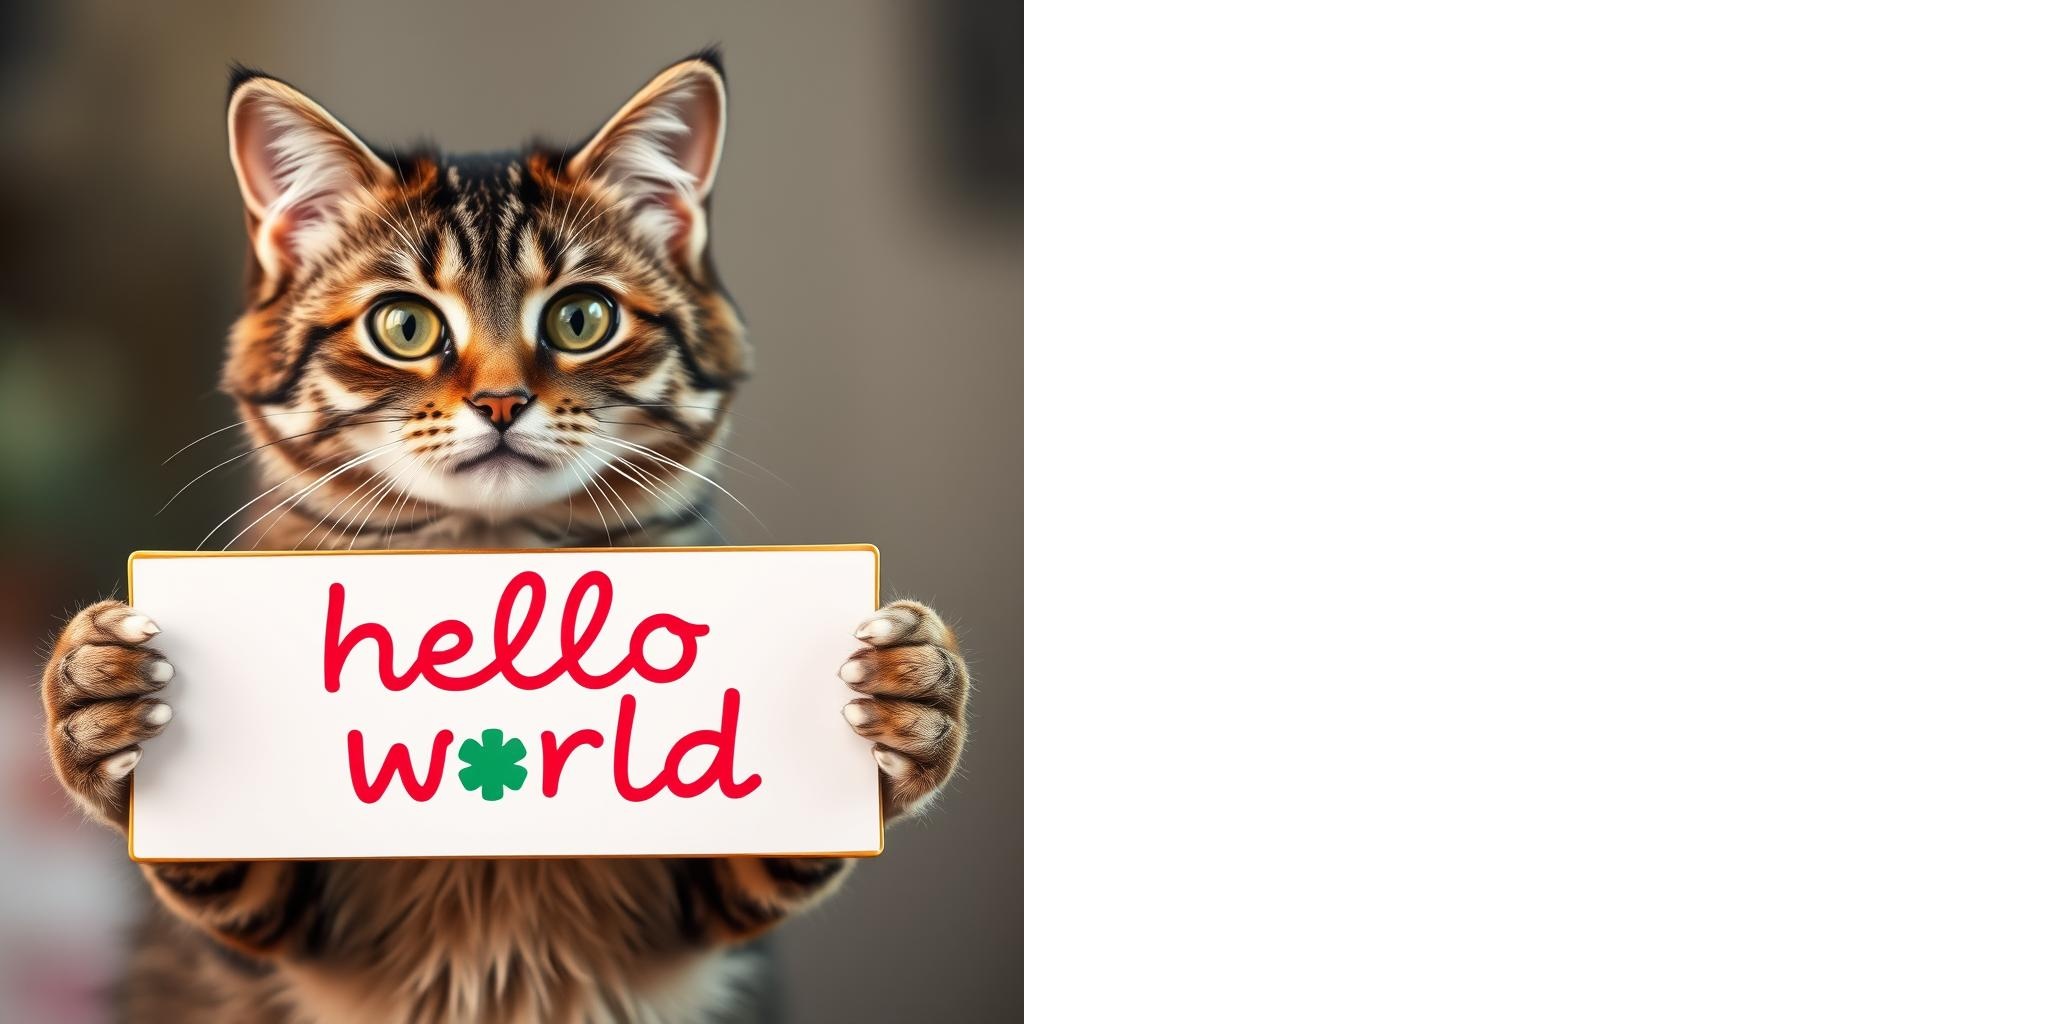

In [5]:
# @title Predict

# @markdown Once deployment succeeds, you can send requests to the endpoint with text prompts.

# @markdown The inference takes ~3s with 1 A100 GPU.

# @markdown Example:

# @markdown ```
# @markdown text: A cat holding a sign that says hello world
# @markdown ```

# @markdown You may adjust the parameters below to achieve best image quality.

text = "A cat holding a sign that says hello world"  # @param {type: "string"}
height = 1024  # @param {type:"number"}
width = 1024  # @param {type:"number"}
num_inference_steps = 4  # @param {type:"number"}

instances = [{"text": text}]
parameters = {
    "height": height,
    "width": width,
    "num_inference_steps": num_inference_steps,
}

# The default num inference steps is set to 4 in the serving container, but
# you can change it to your own preference for image quality in the request.
response = endpoints["endpoint"].predict(instances=instances, parameters=parameters)
images = [
    base64_to_image(prediction.get("output")) for prediction in response.predictions
]
image_grid(images, rows=1)

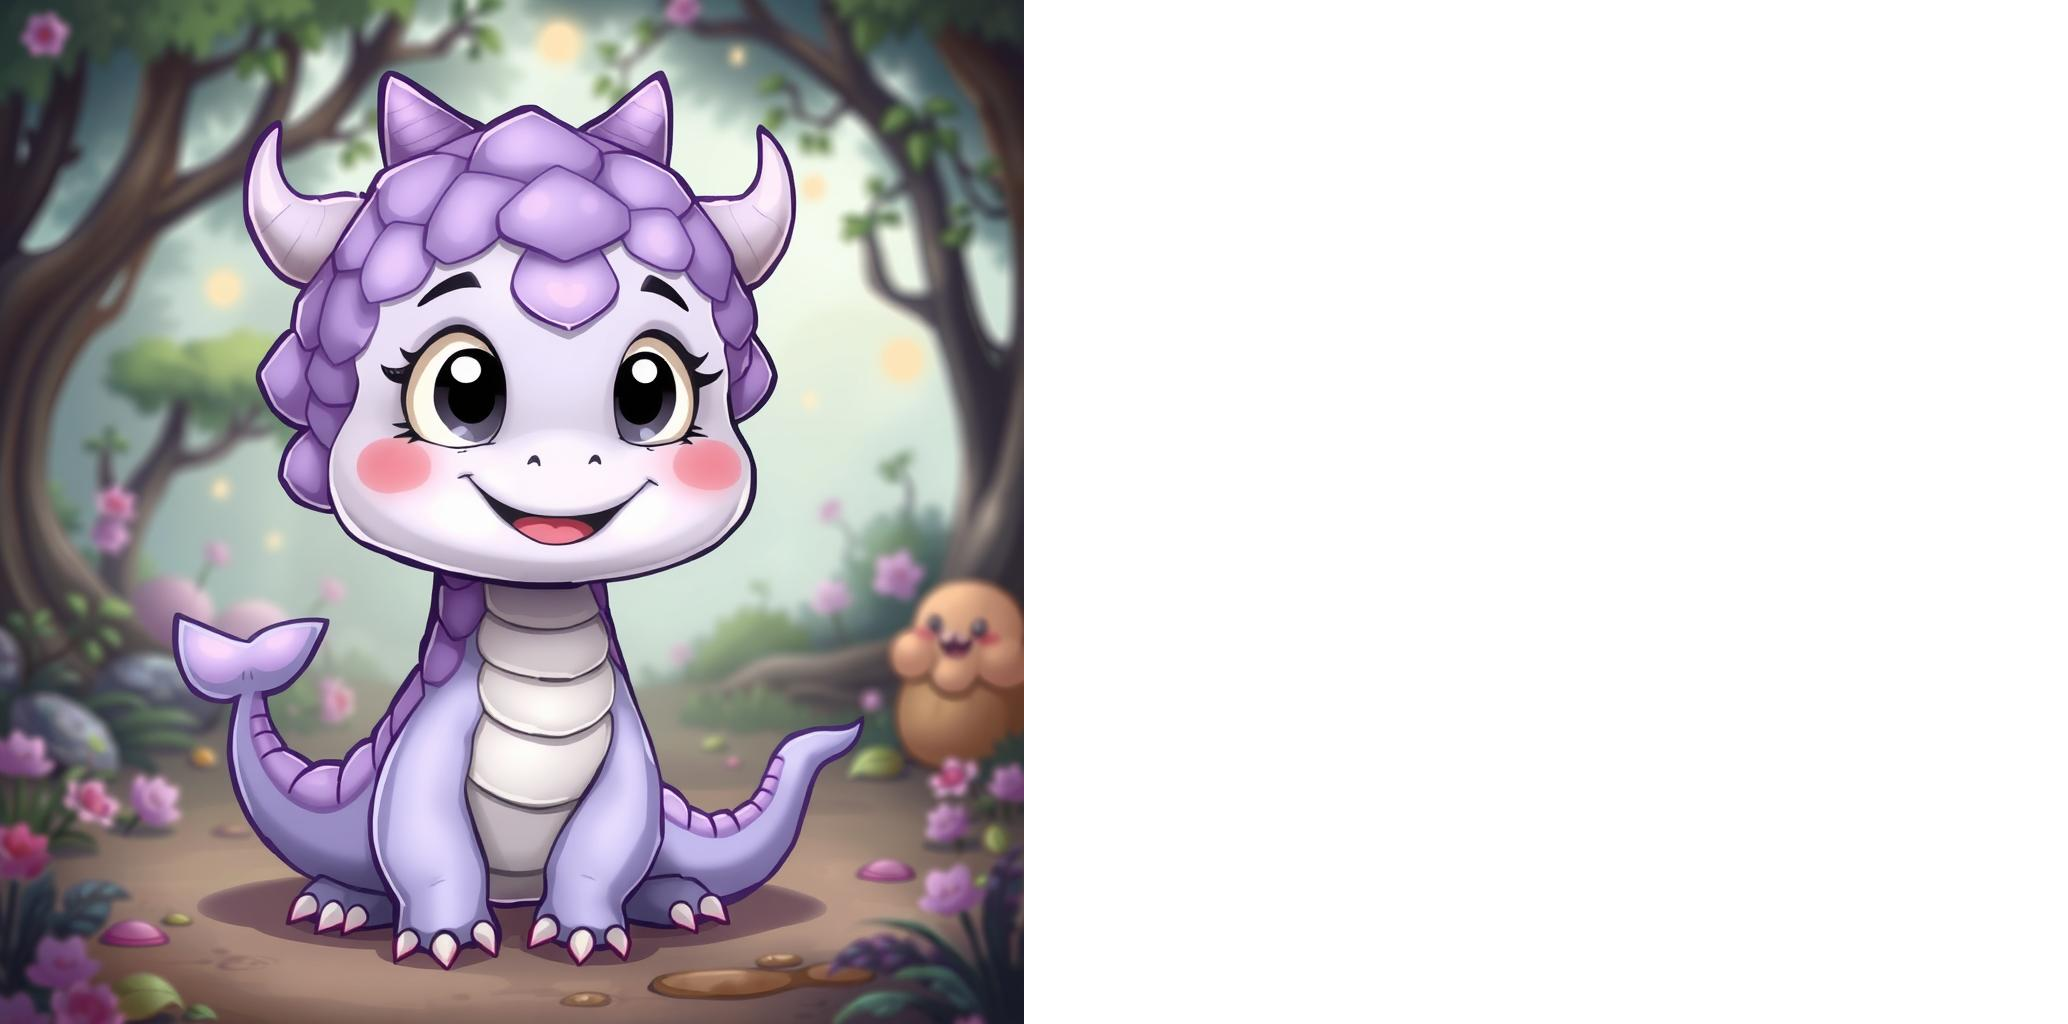

In [6]:
prompt = """
A mythical, cute, cartoonish hydra with a single, large head, covered in soft purple scales.
The hydra has big, expressive eyes and a wide, friendly smile, exuding a cuddly and approachable demeanor.
The body is chubby and playful, with short, rounded limbs and a small, wagging tail.
The background features a whimsical, enchanted forest.
"""
instances = [{"text": prompt}]
parameters = {
    "height": height,
    "width": width,
    "num_inference_steps": num_inference_steps,
}

# The default num inference steps is set to 4 in the serving container, but
# you can change it to your own preference for image quality in the request.
response = endpoints["endpoint"].predict(instances=instances, parameters=parameters)
images = [
    base64_to_image(prediction.get("output")) for prediction in response.predictions
]
image_grid(images, rows=1)

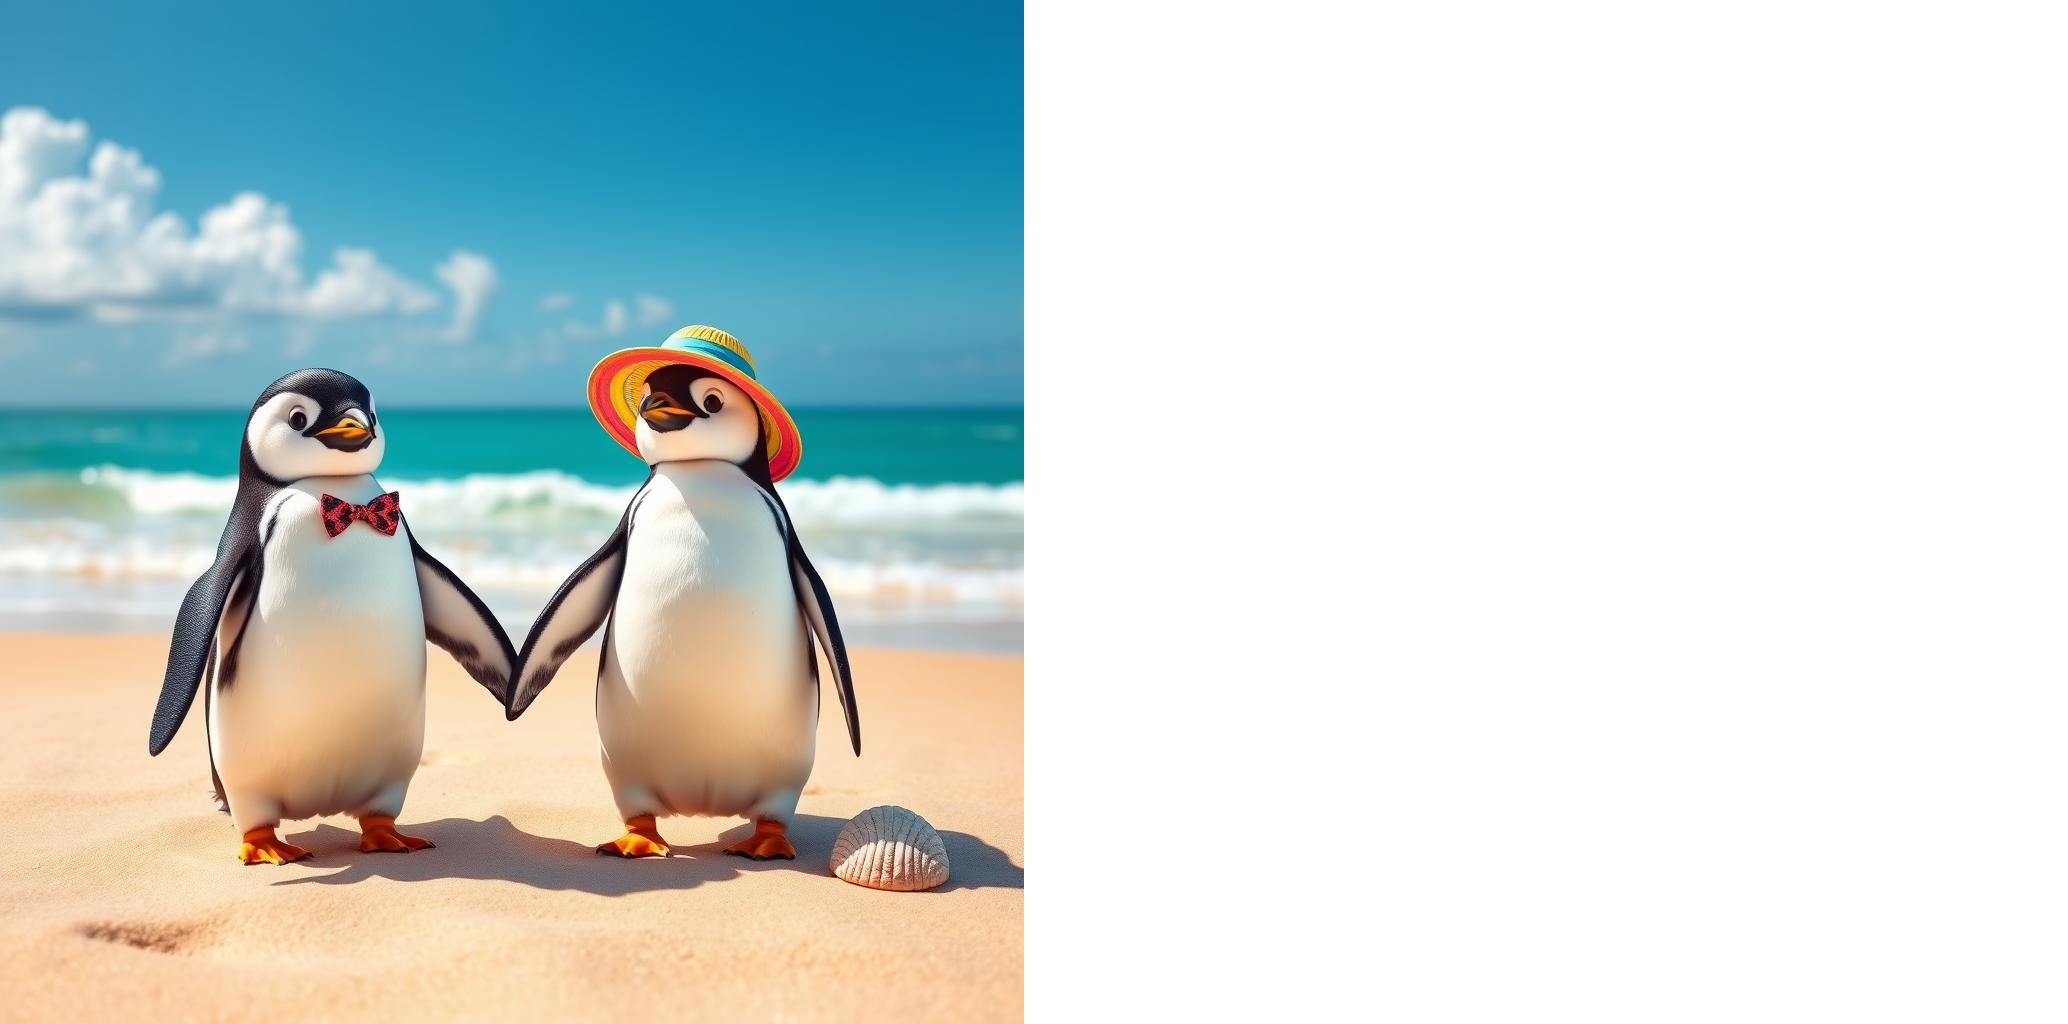

In [7]:
prompt = """
Two adorable penguins holding hands on a sunny beach.
One penguin has a small bowtie, while the other wears a colorful sun hat.
They stand on soft golden sand with gentle ocean waves lapping in the background.
The sky is bright and clear, with a few fluffy clouds, and a seashell lies nearby, adding to the playful, heartwarming scene.
"""
instances = [{"text": prompt}]
parameters = {
    "height": height,
    "width": width,
    "num_inference_steps": num_inference_steps,
}

# The default num inference steps is set to 4 in the serving container, but
# you can change it to your own preference for image quality in the request.
response = endpoints["endpoint"].predict(instances=instances, parameters=parameters)
images = [
    base64_to_image(prediction.get("output")) for prediction in response.predictions
]
image_grid(images, rows=1)

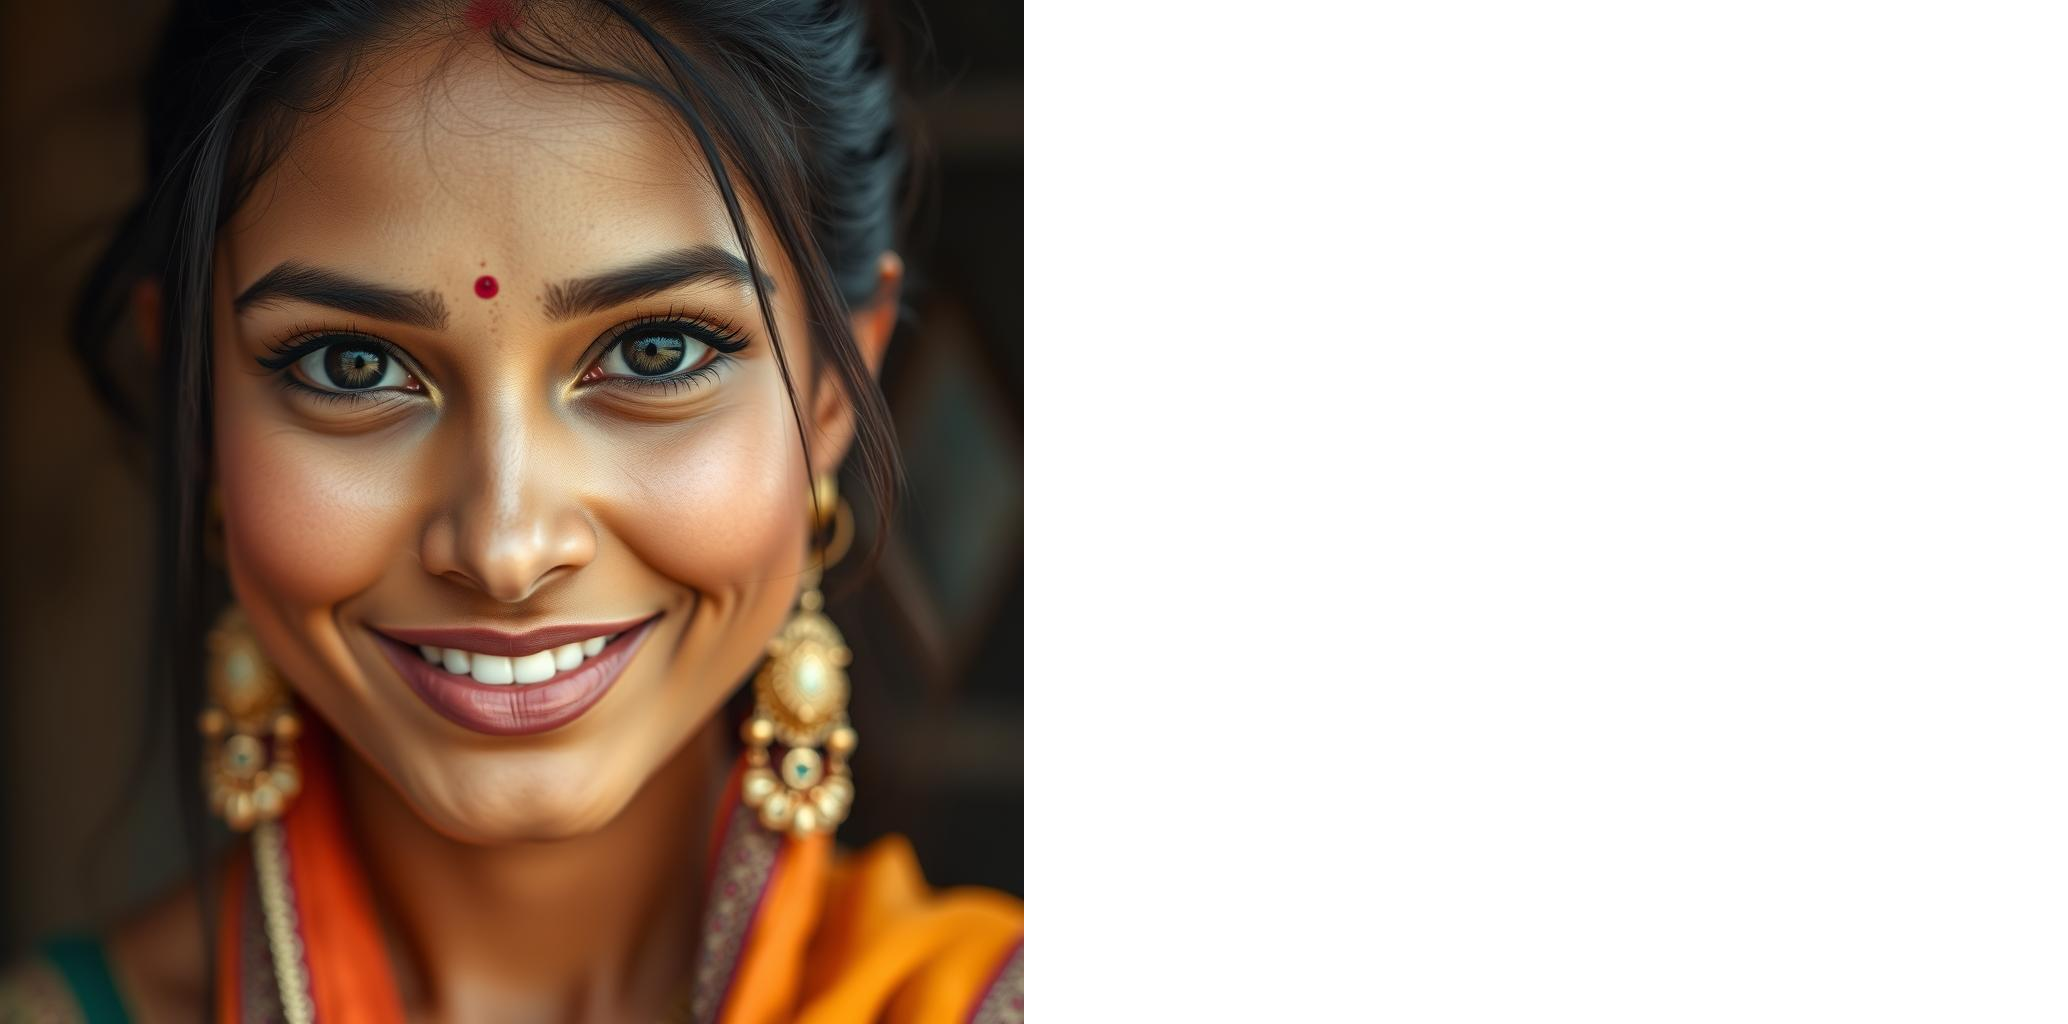

In [9]:
prompt = """Create a highly detailed and realistic portrait of a beautiful indian woman with a warm, inviting smile.
Her expression should convey a subtle, yet captivating sense of allure, with her gaze directed straight at the camera.
Her eyes should sparkle with a mix of charm and confidence, drawing the viewer in.
The background should be blurred, ensuring full focus remains on her expressive face.
"""
instances = [{"text": prompt}]
parameters = {
    "height": height,
    "width": width,
    "num_inference_steps": num_inference_steps,
}

# The default num inference steps is set to 4 in the serving container, but
# you can change it to your own preference for image quality in the request.
response = endpoints["endpoint"].predict(instances=instances, parameters=parameters)
images = [
    base64_to_image(prediction.get("output")) for prediction in response.predictions
]
image_grid(images, rows=1)

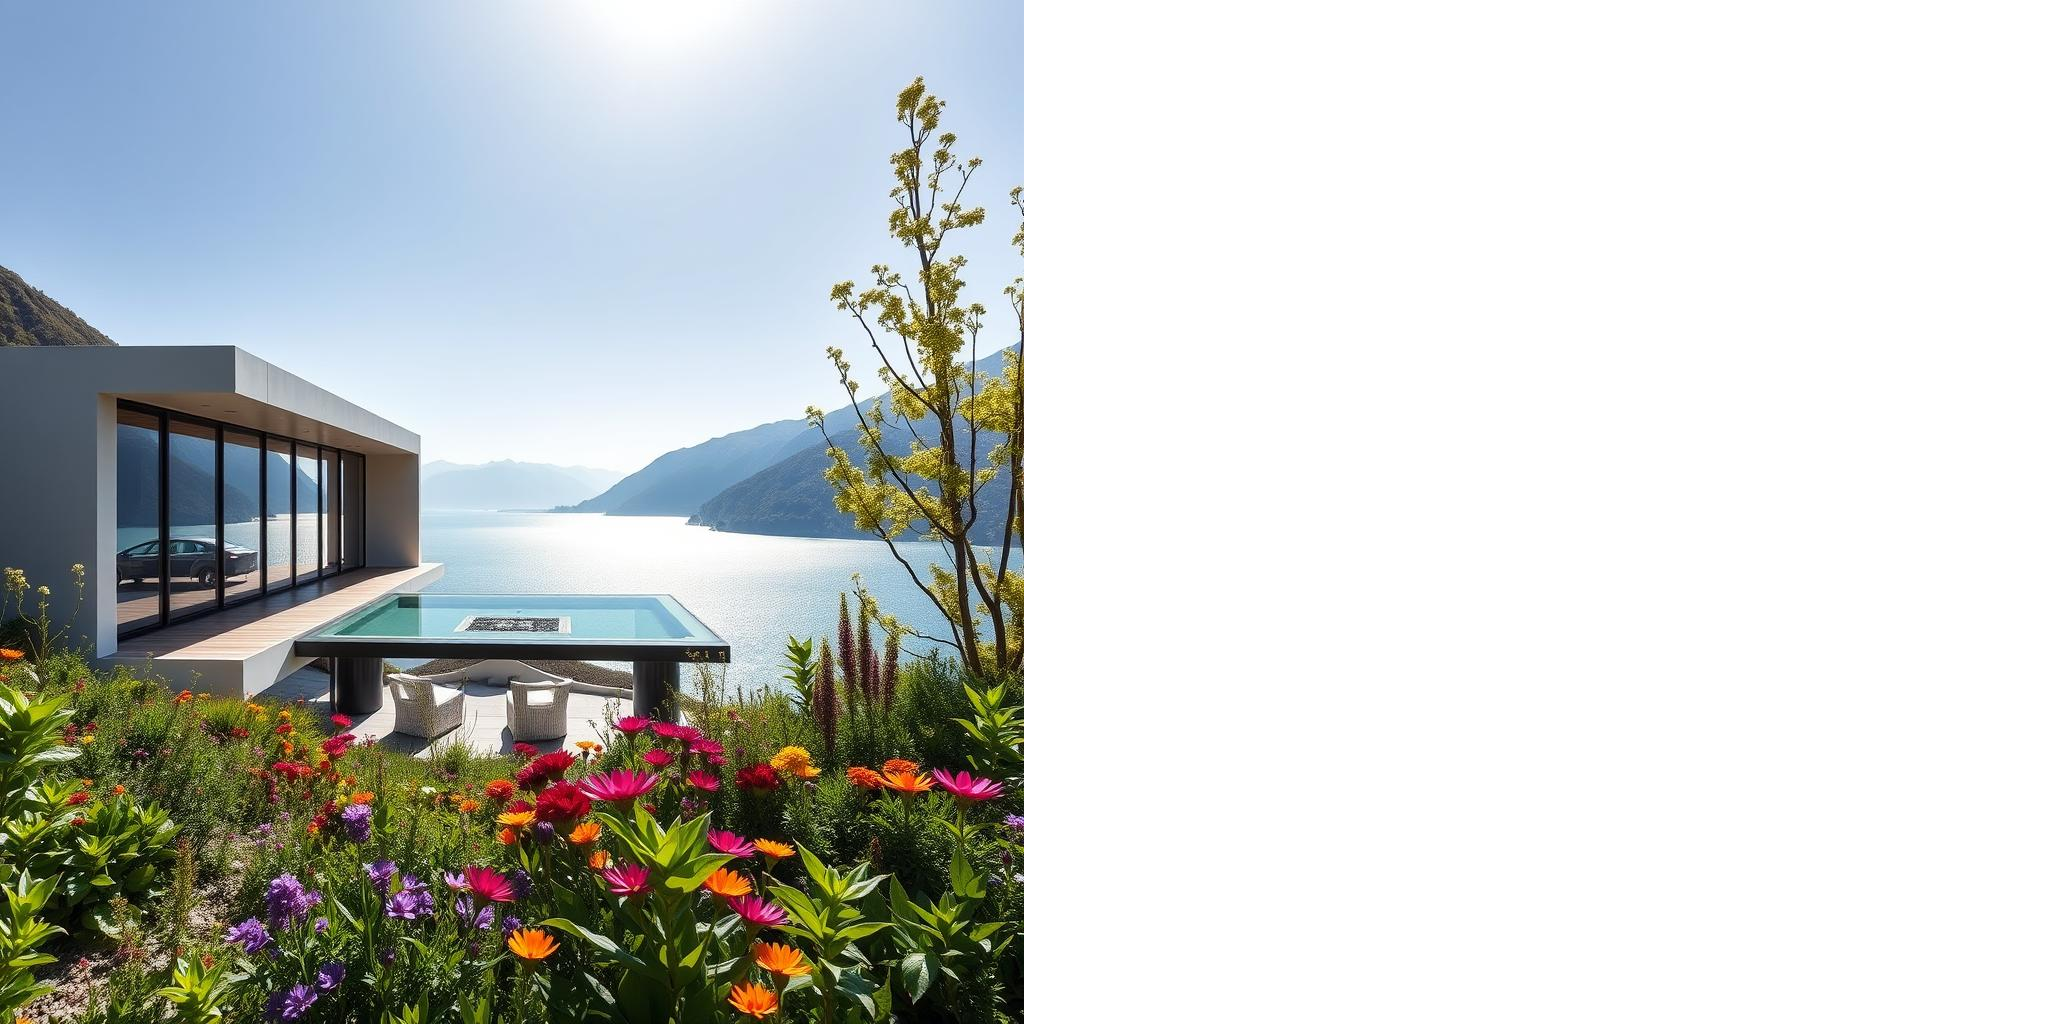

In [14]:
prompt = """A stunning modern himalyan house with sleek architecture and expansive glass windows,
offering a breathtaking view of the sparkling water. The house features clean lines, an open layout, and a spacious deck.
Surrounding it is lush, vibrant greenery with flourishing flora under a bright  sky.
The scene captures a cold high peak mountain himalayas , inviting atmosphere with the shimmering lake in the background.
"""

instances = [{"text": prompt}]
parameters = {
    "height": height,
    "width": width,
    "num_inference_steps": num_inference_steps,
}

# The default num inference steps is set to 4 in the serving container, but
# you can change it to your own preference for image quality in the request.
response = endpoints["endpoint"].predict(instances=instances, parameters=parameters)
images = [
    base64_to_image(prediction.get("output")) for prediction in response.predictions
]
image_grid(images, rows=1)

In [ ]:
# # @title Clean up resources
# # @markdown  Delete the experiment models and endpoints to recycle the resources
# # @markdown  and avoid unnecessary continuous charges that may incur.

# # Undeploy model and delete endpoint.
# for endpoint in endpoints.values():
#     endpoint.delete(force=True)

# # Delete models.
# for model in models.values():
#     model.delete()

# delete_bucket = False  # @param {type:"boolean"}
# if delete_bucket:
#     ! gsutil -m rm -r $BUCKET_NAME